In [7]:

import pandas as pd
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [8]:
def get_good_observations():
    total = 0
    total_unique = 0

    print("GOOD OBSERVATIONS: ")
    games_df = pd.read_csv('data/games.csv', engine='python', on_bad_lines="skip")
    num_observations = len(games_df)
    total+= num_observations
    print("observations of games = ", str(num_observations))
    num_unique = len(games_df.drop_duplicates())
    total_unique += num_unique
    print("unique games = ", str(num_unique))


    plays_df = pd.read_csv('data/plays.csv', engine='python', on_bad_lines="skip")
    num_observations = len(plays_df)
    total+= num_observations
    print("observations of plays = ", str(num_observations))
    num_unique = len(plays_df.drop_duplicates())
    total_unique += num_unique
    print("unique plays = ", str(num_unique))

    print("total observations = ", total)
    print("total unique observations = ", total_unique)
    print("\n")

    return games_df, plays_df

games_df, plays_df = get_good_observations()


GOOD OBSERVATIONS: 
observations of games =  136
unique games =  136
observations of plays =  16124
unique plays =  16124
total observations =  16260
total unique observations =  16260




In [9]:

# take clock string from data and convert to 
def clock_to_seconds(clock_str): 
    minutes, seconds = map(int, clock_str.split(":"))
    return minutes * 60 + seconds



In [10]:
# merge home team from games into plays
plays_df = plays_df.merge(games_df[['gameId', 'homeTeamAbbr']], on='gameId', how='left')

In [11]:
# add gameClockSeconds to df 
plays_df['gameClockSeconds'] = plays_df['gameClock'].apply(clock_to_seconds) 


In [12]:
# add timeRemaining in seconds to df
plays_df['time_remaining'] = (4-plays_df['quarter']) * 15 * 60 + plays_df['gameClockSeconds']

In [13]:
# add score differential from possesion teams view
plays_df['scoreDiff'] = plays_df.apply(
    lambda row: row['preSnapHomeScore'] - row['preSnapVisitorScore']
    if row['possessionTeam'] == row['homeTeamAbbr']
    else row['preSnapVisitorScore'] - row['preSnapHomeScore'], 
    axis = 1
)

In [14]:
# determine distance left to score
plays_df['yardsToScore'] = plays_df.apply(
    lambda row: 100 - row['yardlineNumber']
    if row['yardlineSide'] == row['possessionTeam']
    else row['yardlineNumber'], 
    axis = 1
)

In [15]:
# determine offensive team win probability pre snap 
plays_df['offensiveWinProb'] = plays_df.apply(
    lambda row: row['preSnapHomeTeamWinProbability']
    if row['possessionTeam'] == row['homeTeamAbbr']
    else row['preSnapVisitorTeamWinProbability'], 
    axis = 1
)

In [16]:
# determine play type by parsing playDescription 
# begin run or pass and can later expand to types of runs/passes

# data set does not contain special teams plays but kneels should be filtered
plays_df = plays_df[~plays_df['playDescription'].str.contains('kneel', case = False, na = False) ].copy()

plays_df['playType'] = plays_df['playDescription'].apply(
    lambda desc: 'pass' if 'pass' in str(desc).lower() else 'run'
)

In [17]:
# One-hot encode categorical fields 
# Could be upgraded to embedded encoding for neural network modeling 
encoded = pd.get_dummies(plays_df[['offenseFormation', 'receiverAlignment']], drop_first = True)
plays_df = pd.concat([plays_df, encoded], axis = 1)

In [18]:
# Normilize numerical fields with MinMax scaling 

scaler = MinMaxScaler()
normalized = scaler.fit_transform(plays_df[['yardsToGo', 'yardsToScore', 'scoreDiff', 'time_remaining']])  

# and add it on to the plays_df
normalized_df = pd.DataFrame(normalized, columns = ['yardsToGo_fit', 'yardsToScore_fit', 'scoreDiff_fit', 'time_remaining_fit'])
plays_df = pd.concat([plays_df, normalized_df], axis= 1) 


In [19]:
# define feature matrix X and target variable y
X = plays_df[[
    'quarter', 'down', 'yardsToGo_fit',
    'offensiveWinProb', 'yardsToScore_fit', 'scoreDiff_fit', 'time_remaining_fit'
] + list(encoded.columns)]
y = plays_df['playType'] 

# clean data
mask = y.notnull()
X = X[mask]
y = y[mask]
X = X.dropna()
y = y.loc[X.index]

In [20]:
# split df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y) 

In [22]:
# Begin training with Logistic Regression to establish a baseline
lin_reg_model = LogisticRegression(max_iter = 1000)
lin_reg_model.fit(X_train, y_train)

# predict and evaluate 
from sklearn.metrics import classification_report, confusion_matrix

y_pred = lin_reg_model.predict(X_test)
print("Accuracy from linear regression model: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy from linear regression model:  0.7009493670886076
              precision    recall  f1-score   support

        pass       0.70      0.80      0.74      1726
         run       0.71      0.58      0.64      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.70      3160

[[1378  348]
 [ 597  837]]


In [23]:
# evaluate using Random Forest
from sklearn.ensemble import RandomForestClassifier


rand_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42) 
rand_forest_model.fit(X_train, y_train) 

y_pred = rand_forest_model.predict(X_test)
print("Random Forest Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Random Forest Model Accuracy:  0.6841772151898734
              precision    recall  f1-score   support

        pass       0.70      0.75      0.72      1726
         run       0.67      0.61      0.64      1434

    accuracy                           0.68      3160
   macro avg       0.68      0.68      0.68      3160
weighted avg       0.68      0.68      0.68      3160

[[1292  434]
 [ 564  870]]


In [24]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# scale and classify
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors = 65)) # adjust k for improved accuracy
])

knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test) 

print("KNN model accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

KNN model accuracy:  0.6987341772151898
              precision    recall  f1-score   support

        pass       0.70      0.79      0.74      1726
         run       0.70      0.59      0.64      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.70      3160

[[1358  368]
 [ 584  850]]


In [26]:
from sklearn.svm import SVC 

svm_model = SVC(kernel = 'rbf', probability = True) 
svm_model.fit(X_train, y_train) 

y_pred = svm_model.predict(X_test)
print("SVM Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

SVM Model Accuracy:  0.6984177215189873
              precision    recall  f1-score   support

        pass       0.69      0.80      0.74      1726
         run       0.71      0.57      0.63      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.69      3160

[[1384  342]
 [ 611  823]]


In [27]:
# All models are very close but the linear regression model shows slight improvement over the otheres, 
# particularly on passes with a recall of 0.8 so we will further fine tune this model  

plays_df = plays_df.loc[:, ~plays_df.columns.duplicated()]

# Let's capture some nonlinear relationships these linear models may miss 
plays_df['yardsToGo_scoreDiff'] = plays_df['yardsToGo_fit'] *plays_df['scoreDiff_fit']
plays_df['quarter_time_remaining'] = plays_df['quarter'] * plays_df['time_remaining_fit']
plays_df['yardsToGo_time_remaining'] = plays_df['yardsToGo_fit'] * plays_df['time_remaining_fit']

# and we can classify game scenarios using buckets for time_remaining and score_differential
plays_df['time_bucket'] = pd.cut(
    plays_df['time_remaining_fit'], 
    bins = [0, 120, 600, 1800, 3600],
    labels = ['two_minute', 'late', 'mid', 'early']
)

plays_df['score_diff_bucket'] = pd.cut(
    plays_df['scoreDiff_fit'], 
    bins = [-float('inf'), -10, -8, -3, 0, 3, 8, 10, float('inf')],
    labels = [
        '2 score behind', '1 score behind', 'down 3',
        'tied', 'up 3', '1 score lead', '2 score lead', 'large lead'
    ]
)

plays_df['win_prob_bucket'] = pd.cut(
    plays_df['offensiveWinProb'],
    bins = [0, 0.3, 0.7, 1.0],
    labels = ['low', 'neutral', 'high']
)


# categorize quarters
plays_df['quarter_cat'] = plays_df['quarter'].astype(str) 

# normalize
plays_df = pd.get_dummies(plays_df, columns = ['time_bucket', 'score_diff_bucket', 'quarter_cat', 'win_prob_bucket'], drop_first = True) 

In [28]:
# short yardage
plays_df['short_yardage'] = (plays_df['yardsToGo_fit'] <= 3).astype(int)

# late down
plays_df['high_leverage'] = plays_df['down'].isin([3, 4]).astype(int)

# team is trailing
plays_df['is_trailing'] = (plays_df['scoreDiff_fit'] < 0).astype(int)

# red zone
plays_df['red_zone'] = (plays_df['yardsToScore_fit'] <= 20).astype(int)

In [29]:
# rebuild X
# resplit train and test
# rerun models 

# redefine feature matrix X and target variable y
X = plays_df[[
    'quarter', 'down', 'yardsToGo_fit', 'offensiveWinProb', 'yardsToScore_fit', 'scoreDiff_fit', 'time_remaining_fit',
    'yardsToGo_scoreDiff', 'quarter_time_remaining', 'yardsToGo_time_remaining', 'short_yardage', 'high_leverage', 'is_trailing', 'red_zone'
] + list(encoded.columns) + [col for col in plays_df.columns if col.startswith('time_bucket_') or
                                      col.startswith('score_diff_bucket_') or
                                      col.startswith('win_prob_bucket_') or
                                      col.startswith('quarter_cat_')]]


y = plays_df['playType'] 

# clean data
mask = y.notnull()
X = X[mask]
y = y[mask]
X = X.dropna()
y = y.loc[X.index]

In [30]:
# split df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y) 

In [31]:
# Begin training with Logistic Regression to establish a baseline
lin_reg_model = LogisticRegression(max_iter = 1000)
lin_reg_model.fit(X_train, y_train)

# predict and evaluate 
y_pred = lin_reg_model.predict(X_test)
print("Accuracy from linear regression model: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy from linear regression model:  0.7022151898734177
              precision    recall  f1-score   support

        pass       0.70      0.80      0.75      1726
         run       0.71      0.59      0.64      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.70      3160

[[1376  350]
 [ 591  843]]


In [32]:
# we see slight improvement after the feature extraction
# let's further fine tune with polynomial features
from sklearn.preprocessing import PolynomialFeatures

# build polynomial feature pipeline 
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])
poly_pipeline.fit(X_train, y_train)

# inspect feature importance 
poly_features = poly_pipeline.named_steps['poly'].get_feature_names_out(X.columns)
coefs = poly_pipeline.named_steps['logreg'].coef_[0]

importances = pd.Series(coefs, index=poly_features)
print(importances.sort_values(ascending=False).head(10))



scoreDiff_fit receiverAlignment_4x1                  0.862408
yardsToGo_fit receiverAlignment_4x1                  0.840089
offenseFormation_WILDCAT quarter_cat_2.0             0.678557
quarter receiverAlignment_2x0                        0.549822
score_diff_bucket_tied win_prob_bucket_high          0.525706
yardsToGo_time_remaining offenseFormation_WILDCAT    0.520491
down yardsToGo_scoreDiff                             0.514277
receiverAlignment_2x0 quarter_cat_4.0                0.509784
high_leverage offenseFormation_WILDCAT               0.490527
receiverAlignment_2x0 quarter_cat_3.0                0.485763
dtype: float64


In [33]:
# evaluate performance
y_pred = poly_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        pass       0.70      0.77      0.73      1726
         run       0.68      0.61      0.64      1434

    accuracy                           0.69      3160
   macro avg       0.69      0.69      0.69      3160
weighted avg       0.69      0.69      0.69      3160



In [34]:
# notice the polynomical model is better at predicting runs so we combine the pass focused linear regression model
# with the run focused polynomial model

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier


stackedModel = StackingClassifier(
    estimators = [
        ('logreg', lin_reg_model),
        ('poly', poly_pipeline)
    ],
    final_estimator = LogisticRegression()
)
stackedModel.fit(X_train, y_train)

# evaluate the new model 
y_pred = stackedModel.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        pass       0.70      0.79      0.74      1726
         run       0.70      0.60      0.64      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.70      3160



In [35]:
# Let's add the models from earlier into the stacked model to see potential improvements 

# retrain random forest model 
rand_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42) 
rand_forest_model.fit(X_train, y_train) 

# retrain knn model
knn_model = KNeighborsClassifier(n_neighbors = 65) 
knn_model.fit(X_train, y_train)

# retrain svm model 
svm_model = SVC(kernel = 'rbf', probability = True) 
svm_model.fit(X_train, y_train)


SVC(probability=True)

In [36]:
# add the retrained models to the stacked model 

stackedModel = StackingClassifier(
    estimators = [
        ('logreg', lin_reg_model),
        ('poly', poly_pipeline),
        ('knn', knn_model), 
        ('rand_forst', rand_forest_model), 
        ('svm', svm_model)
    ],
    final_estimator = LogisticRegression()
)
stackedModel.fit(X_train, y_train)

# evaluate the new model 
y_pred = stackedModel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        pass       0.70      0.79      0.74      1726
         run       0.70      0.60      0.65      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.69      3160
weighted avg       0.70      0.70      0.70      3160



In [37]:
# switch final_estimator for potential improved accuracy 

stackedModel = StackingClassifier(
    estimators = [
        ('logreg', lin_reg_model),
        ('poly', poly_pipeline),
        ('knn', knn_model), 
        ('rand_forst', rand_forest_model), 
        ('svm', svm_model)
    ],
    final_estimator = GradientBoostingClassifier()
)
stackedModel.fit(X_train, y_train)

# evaluate the new model 
y_pred = stackedModel.predict(X_test)
print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

        pass       0.71      0.78      0.74      1726
         run       0.69      0.61      0.65      1434

    accuracy                           0.70      3160
   macro avg       0.70      0.69      0.70      3160
weighted avg       0.70      0.70      0.70      3160



In [38]:
# with this we can see an improved recall for run plays with the trade off of 1% worse recall for pass plays
# We'll go with this model for this Checkpoint due to more even overall play classification

# Let's make some predictions 


y_pred = stackedModel.predict(X_test)
probs = stackedModel.predict_proba(X_test)

test_results = X_test.copy()
test_results['predicted_playType'] = y_pred
test_results['pass_prob'] = probs[:, 0]
test_results['run_prob'] = probs[:, 1]
test_results['actual_playType'] = y_test.values
print(test_results[['actual_playType', 'predicted_playType', 'pass_prob', 'run_prob']].head(10))

      actual_playType predicted_playType  pass_prob  run_prob
2646             pass               pass   0.818381  0.181619
10758             run               pass   0.715898  0.284102
11843             run               pass   0.719952  0.280048
14420             run               pass   0.536126  0.463874
2382             pass               pass   0.744442  0.255558
14784             run               pass   0.713776  0.286224
12486             run                run   0.365259  0.634741
3637              run                run   0.261093  0.738907
7915             pass                run   0.346956  0.653044
15703            pass               pass   0.643164  0.356836


In [39]:
# We'll add these results to the plays_df
test_plays = test_results.join(plays_df, how='left', rsuffix='_original')

In [40]:
# Our predictions look pretty good so far but where is it having trouble? 
# Lets look specifically at plays that have low confidence

low_confidence = test_plays[(test_plays['pass_prob'] < 0.55) & (test_plays['run_prob'] < 0.55)]
print(low_confidence[['actual_playType', 'predicted_playType', 'pass_prob', 'run_prob',
                     'down', 'yardsToGo', 'quarter', 'scoreDiff', 'time_remaining_fit']])

      actual_playType predicted_playType  pass_prob  run_prob  down  \
14420             run               pass   0.536126  0.463874   1.0   
4956              run                run   0.479535  0.520465   1.0   
4346              run                run   0.452893  0.547107   1.0   
3279              run                run   0.479193  0.520807   1.0   
1121              run               pass   0.527823  0.472177   1.0   
...               ...                ...        ...       ...   ...   
8495              run               pass   0.538432  0.461568   1.0   
5081             pass                run   0.479193  0.520807   1.0   
9723              run               pass   0.549287  0.450713   1.0   
610               run                run   0.454382  0.545618   1.0   
13157             run               pass   0.545317  0.454683   1.0   

       yardsToGo  quarter  scoreDiff  time_remaining_fit  
14420        1.0      3.0       10.0            0.607381  
4956        10.0      3.0    

In [41]:
# As we can see, much of the entries the model has a difficult time with come from larger deficits, 
# on early downs, with a moderate amount of yards to go

# Now let's predict under some more specific situations: 
# print(plays_df.sort_values(by='yardsToScore', ascending = False).head(10))

# Red Zone, 3rd Down, with > 5 yards to gain 
redzone_3rd_long = plays_df[
    (plays_df['down'] == 3) &
    (plays_df['yardsToGo'] > 0.5) &
    (plays_df['yardsToScore'] <= 20)
].copy()

# Inside a team's own 5 yard line
inside_own_5 = plays_df[
    (plays_df['yardsToScore'] >= 95)
].copy()

# Under two minutes in the game and trailing 
two_min_drill = plays_df[
    (plays_df['time_remaining'] <= 120) & 
    (plays_df['scoreDiff'] < 0)
].copy()


In [44]:
# evaluate redzone_3rd_long

# clean
scenario_df = redzone_3rd_long
scenario_df = scenario_df.loc[:, ~scenario_df.columns.duplicated()]
scenario_features = scenario_df.reindex(columns=X_train.columns, fill_value=0)
scenario_features = scenario_features.dropna()
scenario_df = scenario_df.loc[scenario_features.index]

# Predict
scenario_df['predicted_playType'] = stackedModel.predict(scenario_features)
probs = stackedModel.predict_proba(scenario_features)
scenario_df['pass_prob'] = probs[:, 0]
scenario_df['run_prob'] = probs[:, 1]

print(scenario_df[['yardsToScore', 'down', 'yardsToGo_fit', 'yardlineNumber', 'time_remaining_fit', 'playType', 'predicted_playType', 'pass_prob', 'run_prob']].head(10))

     yardsToScore  down  yardsToGo_fit  yardlineNumber  time_remaining_fit  \
10           15.0   3.0       0.243243            15.0            0.371943   
16           20.0   3.0       0.000000            20.0            0.238995   
40            1.0   3.0       0.027027             1.0            0.230547   
43           13.0   3.0       0.108108            13.0            0.499778   
64           20.0   3.0       0.162162            20.0            0.703424   
137           6.0   3.0       0.243243             6.0            0.869498   
182          16.0   3.0       0.243243            16.0            0.263228   
185          18.0   3.0       0.000000            18.0            0.682081   
190          13.0   3.0       0.243243            13.0            0.738550   
261          11.0   3.0       0.243243            11.0            0.998888   

    playType predicted_playType  pass_prob  run_prob  
10      pass               pass   0.733995  0.266005  
16      pass               pass

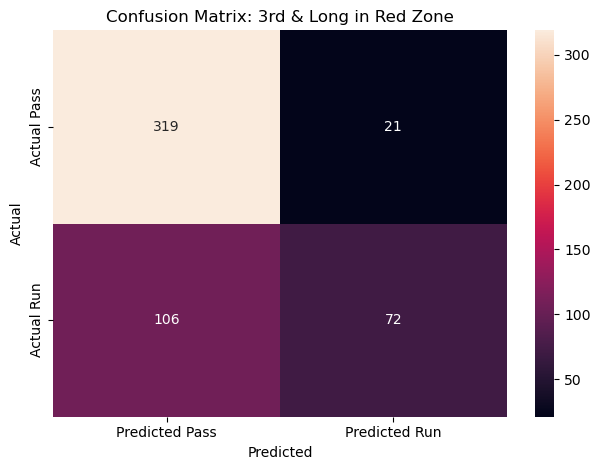

In [45]:
# visualize redzone_3rd_long

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(scenario_df['playType'], scenario_df['predicted_playType'], labels=['pass', 'run'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Pass', 'Predicted Run'], yticklabels=['Actual Pass', 'Actual Run'])
plt.title('Confusion Matrix: 3rd & Long in Red Zone')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [47]:
# evaluate inside_own_5
# clean
scenario_df = inside_own_5
scenario_df = scenario_df.loc[:, ~scenario_df.columns.duplicated()]
scenario_features = scenario_df.reindex(columns=X_train.columns, fill_value=0)
scenario_features = scenario_features.dropna()
scenario_df = scenario_df.loc[scenario_features.index]

# Predict
scenario_df['predicted_playType'] = stackedModel.predict(scenario_features)
probs = stackedModel.predict_proba(scenario_features)
scenario_df['pass_prob'] = probs[:, 0]
scenario_df['run_prob'] = probs[:, 1]

print(scenario_df[['yardsToScore', 'down', 'yardsToGo_fit', 'yardlineNumber', 'time_remaining_fit', 'playType', 'predicted_playType', 'pass_prob', 'run_prob']].head(10))

      yardsToScore  down  yardsToGo_fit  yardlineNumber  time_remaining_fit  \
484           96.0   1.0       0.351351             4.0            0.214540   
493           97.0   1.0       0.243243             3.0            0.267897   
920           98.0   1.0       0.243243             2.0            0.459982   
1253          97.0   2.0       0.243243             3.0            0.496443   
1313          99.0   1.0       0.243243             1.0            0.331036   
1425          98.0   1.0       0.243243             2.0            0.717208   
1822          99.0   1.0       0.243243             1.0            0.463762   
1872          99.0   2.0       0.216216             1.0            0.472877   
1875          95.0   1.0       0.135135             5.0            0.215874   
1886          99.0   1.0       0.243243             1.0            0.614051   

     playType predicted_playType  pass_prob  run_prob  
484       run                run   0.272425  0.727575  
493      pass     

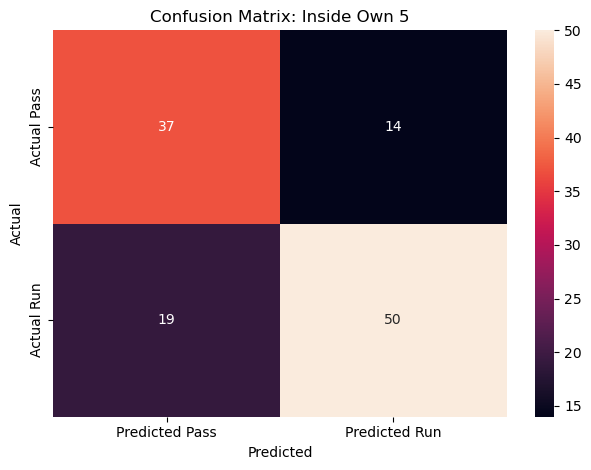

In [48]:
# visualize own_5
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(scenario_df['playType'], scenario_df['predicted_playType'], labels=['pass', 'run'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Pass', 'Predicted Run'], yticklabels=['Actual Pass', 'Actual Run'])
plt.title('Confusion Matrix: Inside Own 5')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [49]:
# evaluate two_min_drill
# clean
scenario_df = two_min_drill
scenario_df = scenario_df.loc[:, ~scenario_df.columns.duplicated()]
scenario_features = scenario_df.reindex(columns=X_train.columns, fill_value=0)
scenario_features = scenario_features.dropna()
scenario_df = scenario_df.loc[scenario_features.index]

# Predict
scenario_df['predicted_playType'] = stackedModel.predict(scenario_features)
probs = stackedModel.predict_proba(scenario_features)
scenario_df['pass_prob'] = probs[:, 0]
scenario_df['run_prob'] = probs[:, 1]

print(scenario_df[['down', 'yardsToGo_fit', 'yardlineNumber', 'time_remaining_fit', 'playType', 'predicted_playType', 'pass_prob', 'run_prob']].head(10))

     down  yardsToGo_fit  yardlineNumber  time_remaining_fit playType  \
2     3.0       0.297297            20.0            0.226323     pass   
6     1.0       0.243243            40.0            0.206092      run   
61    1.0       0.000000            38.0            0.957092     pass   
68    1.0       0.243243            41.0            0.362606     pass   
86    2.0       0.270270             3.0            0.580925     pass   
107   2.0       0.243243            15.0            1.000000      run   
127   2.0       0.108108            32.0            0.435972      run   
164   1.0       0.243243            25.0            0.467319     pass   
196   1.0       0.162162            32.0            0.227879      run   
219   3.0       0.243243            23.0            0.844375     pass   

    predicted_playType  pass_prob  run_prob  
2                 pass   0.818510  0.181490  
6                 pass   0.689639  0.310361  
61                pass   0.849823  0.150177  
68          

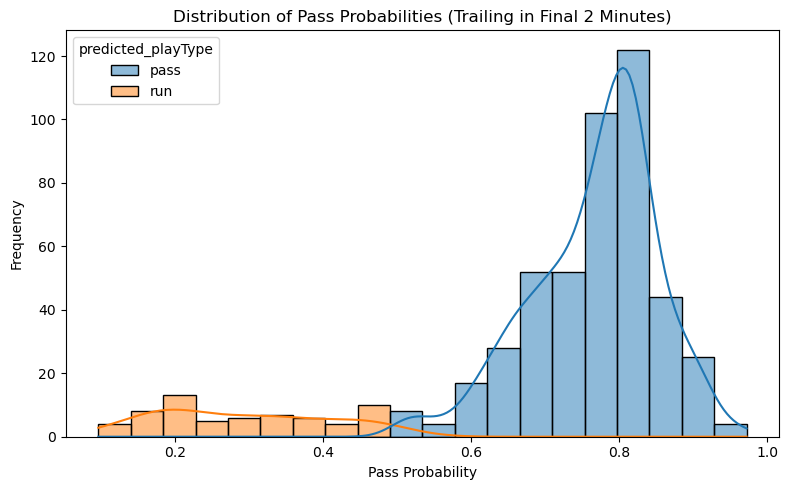

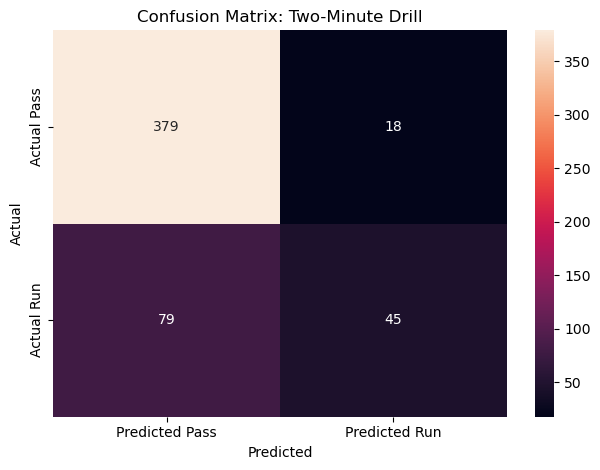

In [50]:
# visualize two_min_drill
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=scenario_df, x='pass_prob', hue='predicted_playType', bins=20, kde=True)
plt.title('Distribution of Pass Probabilities (Trailing in Final 2 Minutes)')
plt.xlabel('Pass Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

cm = confusion_matrix(scenario_df['playType'], scenario_df['predicted_playType'], labels=['pass', 'run'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Pass', 'Predicted Run'], yticklabels=['Actual Pass', 'Actual Run'])
plt.title('Confusion Matrix: Two-Minute Drill')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
